In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# Object description

We are going to use the Hu Moments to describe and group different objects in images. In the folder called _data_ you can find a simple image with different objects.

## Load and binarize the image

The first job is to load the image and binarize it. It is important to load the image using the `cv2.IMREAD_GRAYSCALE` parameter in order to obtain a 2D matrix. Show the binarized image in order to check this part of the process.

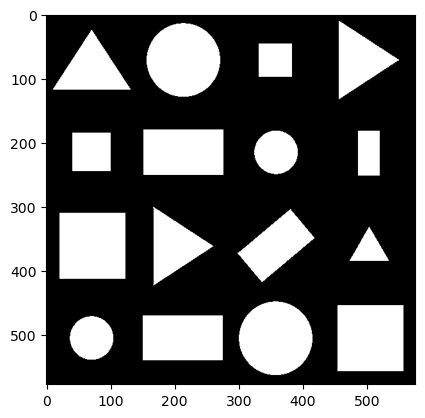

In [2]:
filename = "../data/simple_shapes.png"
im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
_, im_th = cv2.threshold(im, 254, 255, cv2.THRESH_BINARY_INV)
plt.imshow(im_th, cmap="gray")
plt.show()

## Contour detection

As you did in the segmentation assignment of the Image Analysis subject, you have to use the `findContours` function to detect all the objects in the image. In order to check if you have performed a correct detection you have to draw the contours on the image and visualize them.

_Extra_: Given a contour, you can obtain its bounding box by using the `boundingRect` function.


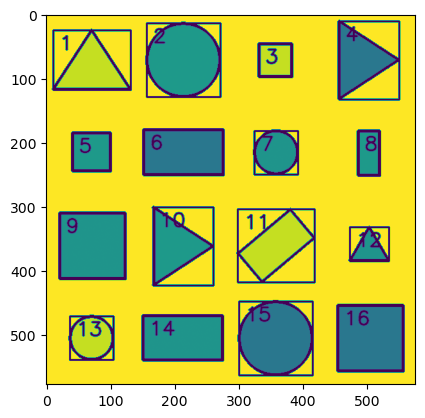

In [3]:
contours, _ = cv2.findContours(im_th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img = im.copy()

def sort_contours(cnts):
    reverse = False
    i = 0

    # construct the list of bounding boxes and sort them from left right and top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    sorted_cnts, sorted_boundingBoxes = [], []
    row_splitter_1 = 125
    row_splitter_2 = 0
    for i in range(4):
        for cnt, boundingBox in zip(cnts, boundingBoxes):
            if boundingBox[1] < row_splitter_1 and boundingBox[1] > row_splitter_2:
                sorted_cnts.append(cnt)
                sorted_boundingBoxes.append(boundingBox)
        row_splitter_1 += 125
        row_splitter_2 += 125
    # return the list of sorted contours and bounding boxes
    return (sorted_cnts, sorted_boundingBoxes)

contours, boundingBoxes = sort_contours(contours)

# list for storing names of shapes
for contour in contours:
    cv2.drawContours(img, [contour], 0, (0, 0, 255), 3)

i = 0
for rect in boundingBoxes:
    x,y,w,h = rect
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),2)
    cv2.putText(img, text= str(i+1), org=(x+10,y+30),
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
            thickness=2, lineType=cv2.LINE_AA)
    i+= 1

plt.imshow(img)
plt.show()

## Descriptor

As we stated before, you are going to describe each object by means of the *moments*. _OpenCV_ has a built-in function for calculating Hu Moments. It is called `HuMoments` and it takes as input the central moments of the image which can be calculated using the function `moments`. The function `moments` can receive a binary image or a set of points describing a contour.

The Hu Moments obtained have a large range, so we can apply a log transform by using next code: `moment_i = -1* copysign(1.0, moment_i) * log10(abs(moment_i)))`. The `copysign` and `log10` functions are part of the _math_ library.


In [10]:
# import math
humoments_contours = []
for contour in contours:
   # Calculate Moments
   moments = cv2.moments(contour) 
   # Calculate Hu Moments 
   huMoments = cv2.HuMoments(moments)
   # Log scale hu moments 
   for i in range(0,7):
      huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i])+1)
   humoments_contours.append(huMoments)

## Shape matching

Now you have a descriptor for each object. Next step is to calculate the euclidean distance between the shapes and try to obtain groups of similar objects.

**This is a challenging step!!**

In [11]:
groups = {}
group_key = 1
grouped_index = []
for i in range(16):
    for j in range(16):
        if j == i:
            # print(i+1, j+1, 0)
            if j not in grouped_index:
                groups[group_key] = [j]
                grouped_index.append(j)
            continue
        if j in grouped_index:
            continue
        distance = np.linalg.norm(humoments_contours[i] - humoments_contours[j])
        if distance <= 0.002:
            # print(i+1, j+1, '{:.10f}'.format(np.round(distance, 10)))
            groups[group_key] = groups[group_key] + [j]
            grouped_index.append(j)
    group_key += 1
print(groups)

{1: [0, 3, 9, 11], 2: [1, 6, 12, 14], 3: [2, 4, 8, 15], 6: [5, 10, 13], 8: [7]}


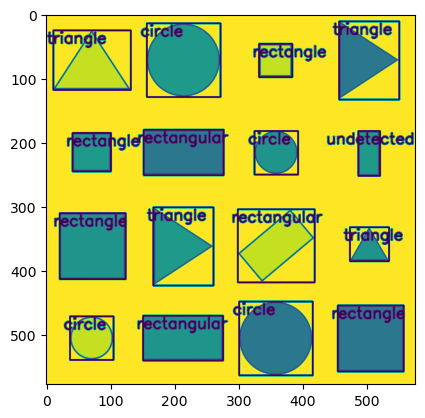

In [12]:
img = im.copy()

def find_group(idx):
    result = ""
    for key in groups:
        if idx in groups[key]:
            if key == 1:
                result = "triangle"
            if key == 2:
                result = "circle"
            if key == 3:
                result = "rectangle"
            if key == 6:
                result = "rectangular"
            if key == 8:
                result = "undetected"
    return result

idx = 0
for rect in boundingBoxes:
    group = find_group(idx)
    x,y,w,h = rect
    label_pos = (0, 0)
    if idx == 7:
        label_pos = (x-50, y+20)
    else:
        label_pos = (x-10, y+20)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),2)
    cv2.putText(img, text= group, org=label_pos,
            fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(0,0,0),
            thickness=2, lineType=cv2.LINE_AA)
    idx+= 1

plt.imshow(img)
plt.show()